<a href="https://colab.research.google.com/github/bondpy202212/AI_projects/blob/main/6_Transfer_Learning(Cats_vs_Dogs_Dataset).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Imports**

In [1]:
import os
import shutil
import zipfile
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img

**Dataset**\
https://www.kaggle.com/c/dogs-vs-cats/data

In [2]:
!wget --no-check-certificate \
    -q "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip" \
    -O "/tmp/cats-and-dogs.zip"


local_zip = '/tmp/cats-and-dogs.zip'
zip_ref   = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/')
zip_ref.close()


source_path = '/tmp/PetImages'
del_photo = 0.88
source_path_dogs = os.path.join(source_path, 'Dog')
source_path_cats = os.path.join(source_path, 'Cat')

# Deleting some of the photos of the dogs
dog_images = os.listdir(source_path_dogs)
num_dog_images_to_delete = int(del_photo * len(dog_images))
images_to_delete = random.sample(dog_images, num_dog_images_to_delete)
for image in images_to_delete:
    os.remove(os.path.join(source_path_dogs, image))

# Deleting some of the photos of the cats
cat_images = os.listdir(source_path_cats)
num_cat_images_to_delete = int(del_photo * len(cat_images))
images_to_delete = random.sample(cat_images, num_cat_images_to_delete)
for image in images_to_delete:
    os.remove(os.path.join(source_path_cats, image))


# os.listdir returns a list containing all files under the given path
print(f"There are {len(os.listdir(source_path_dogs))} images of dogs.")
print(f"There are {len(os.listdir(source_path_cats))} images of cats.")

There are 1501 images of dogs.
There are 1501 images of cats.


**Subdirectories for training and validation**

In [3]:
#  Define root directory
root_dir = '/tmp/cats-v-dogs'

# Empty directory to prevent FileExistsError is the function is run several times
if os.path.exists(root_dir):
  shutil.rmtree(root_dir)

def create_train_val_dirs(root_path):
  """
  Creates directories for the train and test sets

  Args:
    root_path (string) - the base directory path to create subdirectories from

  Returns:
    None
  """

  path_tcats = root_dir + '/training/cats'
  os.makedirs(path_tcats)

  path_vcats = root_dir + '/validation/cats'
  os.makedirs(path_vcats)

  path_tdogs = root_dir + '/training/dogs'
  os.makedirs(path_tdogs)

  path_vdogs = root_dir + '/validation/dogs'
  os.makedirs(path_vdogs)


try:
  create_train_val_dirs(root_path=root_dir)
except FileExistsError:
  print("You should not be seeing this since the upper directory is removed beforehand")

In [4]:
for rootdir, dirs, files in os.walk(root_dir):
    for subdir in dirs:
        print(os.path.join(rootdir, subdir))

/tmp/cats-v-dogs/training
/tmp/cats-v-dogs/validation
/tmp/cats-v-dogs/training/cats
/tmp/cats-v-dogs/training/dogs
/tmp/cats-v-dogs/validation/cats
/tmp/cats-v-dogs/validation/dogs


In [5]:
def split_data(SOURCE_DIR, TRAINING_DIR, VALIDATION_DIR, SPLIT_SIZE):
  """
  Splits the data into train and test sets

  Args:
    SOURCE_DIR (string): directory path containing the images
    TRAINING_DIR (string): directory path to be used for training
    VALIDATION_DIR (string): directory path to be used for validation
    SPLIT_SIZE (float): proportion of the dataset to be used for training

  Returns:
    None
  """

  # Get a list of all files in the SOURCE_DIR
  files = os.listdir(SOURCE_DIR)
  # Remove files with zero length from consideration
  valid_files = [file for file in files if os.path.getsize(os.path.join(SOURCE_DIR, file)) > 0 ]
  for file in files:
    if os.path.getsize(os.path.join(SOURCE_DIR, file)) > 0:
      pass
    else:
      print(f"{file} is zero length, so ignoring.")

  # Randomly shuffle the list of valid files
  random.shuffle(valid_files)
  # Calculate the split index
  split_index = int(SPLIT_SIZE * len(valid_files))

  # Split the files into training and validation sets
  training_files = valid_files[:split_index]
  validation_files = valid_files[split_index:]

  # Copy files to the training directory
  for file in training_files:
      source_file = os.path.join(SOURCE_DIR, file)
      destination_file = os.path.join(TRAINING_DIR, file)
      shutil.copy(source_file, destination_file)

  # Copy files to the validation directory
  for file in validation_files:
      source_file = os.path.join(SOURCE_DIR, file)
      destination_file = os.path.join(VALIDATION_DIR, file)
      shutil.copy(source_file, destination_file)

In [6]:
# Define paths
CAT_SOURCE_DIR = "/tmp/PetImages/Cat/"
DOG_SOURCE_DIR = "/tmp/PetImages/Dog/"

TRAINING_DIR = "/tmp/cats-v-dogs/training/"
VALIDATION_DIR = "/tmp/cats-v-dogs/validation/"

TRAINING_CATS_DIR = os.path.join(TRAINING_DIR, "cats/")
VALIDATION_CATS_DIR = os.path.join(VALIDATION_DIR, "cats/")

TRAINING_DOGS_DIR = os.path.join(TRAINING_DIR, "dogs/")
VALIDATION_DOGS_DIR = os.path.join(VALIDATION_DIR, "dogs/")

# Empty directories in case you run this cell multiple times
if len(os.listdir(TRAINING_CATS_DIR)) > 0:
  for file in os.scandir(TRAINING_CATS_DIR):
    os.remove(file.path)
if len(os.listdir(TRAINING_DOGS_DIR)) > 0:
  for file in os.scandir(TRAINING_DOGS_DIR):
    os.remove(file.path)
if len(os.listdir(VALIDATION_CATS_DIR)) > 0:
  for file in os.scandir(VALIDATION_CATS_DIR):
    os.remove(file.path)
if len(os.listdir(VALIDATION_DOGS_DIR)) > 0:
  for file in os.scandir(VALIDATION_DOGS_DIR):
    os.remove(file.path)

# Define proportion of images used for training
split_size = .75

# Run the function
# NOTE: Messages about zero length images should be printed out
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, VALIDATION_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, VALIDATION_DOGS_DIR, split_size)

# Check that the number of images matches the expected output

# Your function should perform copies rather than moving images so original directories should contain unchanged images
print(f"\n\nOriginal cat's directory has {len(os.listdir(CAT_SOURCE_DIR))} images")
print(f"Original dog's directory has {len(os.listdir(DOG_SOURCE_DIR))} images\n")

# Training and validation splits
print(f"There are {len(os.listdir(TRAINING_CATS_DIR))} images of cats for training")
print(f"There are {len(os.listdir(TRAINING_DOGS_DIR))} images of dogs for training")
print(f"There are {len(os.listdir(VALIDATION_CATS_DIR))} images of cats for validation")
print(f"There are {len(os.listdir(VALIDATION_DOGS_DIR))} images of dogs for validation")



Original cat's directory has 1501 images
Original dog's directory has 1501 images

There are 1125 images of cats for training
There are 1125 images of dogs for training
There are 376 images of cats for validation
There are 376 images of dogs for validation


**Take a look at a sample image of each one of the classes**

Sample cat image:


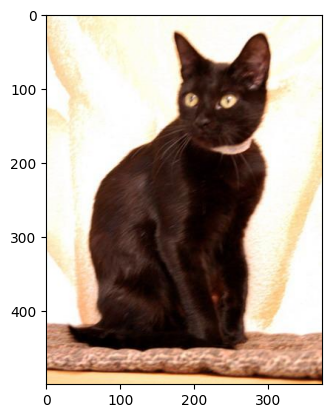


Sample dog image:


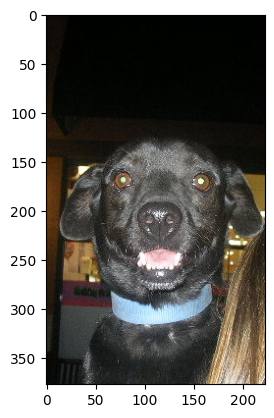

In [7]:
print("Sample cat image:")
plt.imshow(load_img(f"{os.path.join(TRAINING_CATS_DIR, os.listdir(TRAINING_CATS_DIR)[0])}"))
plt.show()

print("\nSample dog image:")
plt.imshow(load_img(f"{os.path.join(TRAINING_DOGS_DIR, os.listdir(TRAINING_DOGS_DIR)[0])}"))
plt.show()

**Training and Validation Generators**

In [8]:
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):
  """
  Creates the training and validation data generators

  Args:
    TRAINING_DIR (string): directory path containing the training images
    VALIDATION_DIR (string): directory path containing the testing/validation images

  Returns:
    train_generator, validation_generator - tuple containing the generators
  """

  # Instantiate the ImageDataGenerator class
  train_datagen = ImageDataGenerator( rescale = 1.0 / 255.0)

  # Pass in the appropriate arguments to the flow_from_directory method
  train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=20,
                                                      class_mode='binary',
                                                      target_size=(150, 150))

  # Instantiate the ImageDataGenerator class
  validation_datagen = ImageDataGenerator( rescale = 1.0 / 255.0)

  # Pass in the appropriate arguments to the flow_from_directory method
  validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                batch_size=20,
                                                                class_mode='binary',
                                                                target_size=(150, 150))

  return train_generator, validation_generator

**Test the generators**

In [9]:
train_generator, validation_generator = train_val_generators(TRAINING_DIR, VALIDATION_DIR)

Found 2250 images belonging to 2 classes.
Found 752 images belonging to 2 classes.


**Transfer learning - Create the pre-trained model**

In [10]:
# Download the inception v3 weights
!wget --no-check-certificate \
    -q https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

In [11]:
# Create an instance of the inception model from the local pre-trained weights
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

**Complete the create_pre_trained_model function**

In [12]:
def create_pre_trained_model(local_weights_file):
  """
  Initializes an InceptionV3 model.

  Args:
    local_weights_file (string): path pointing to a pretrained weights H5 file

  Returns:
    pre_trained_model: the initialized InceptionV3 model
  """

  pre_trained_model = InceptionV3(input_shape = (150, 150, 3),
                                  include_top = False,
                                  weights = None)

  pre_trained_model.load_weights(local_weights_file)

  # Make all the layers in the pre-trained model non-trainable
  for layer in pre_trained_model.layers:
    layer.trainable = False

  return pre_trained_model

**Create pre trained model**

In [13]:
pre_trained_model = create_pre_trained_model(local_weights_file)

# Print the model summary
pre_trained_model.summary()

Model: "inception_v3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 150, 150, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 74, 74, 32)     │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 74, 74, 32)     │             96 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 74, 74, 32)     │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 72, 72, 32)     │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 72, 72, 32)     │             96 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 72, 72, 32)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 72, 72, 64)     │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 72, 72, 64)     │            192 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 72, 72, 64)     │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 35, 35, 64)     │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 35, 35, 80)     │          5,120 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 35, 35, 80)     │            240 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 35, 35, 80)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 33, 33, 192)    │        138,240 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 33, 33, 192)    │            576 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activat

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 21,802,784 (83.17 MB)

**To check that all the layers in the model were set to be non-trainable**

In [14]:
total_params = pre_trained_model.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in pre_trained_model.trainable_weights])

print(f"There are {total_params:,} total parameters in this model.")
print(f"There are {num_trainable_params:,} trainable parameters in this model.")

There are 21,802,784 total parameters in this model.
There are 0 trainable parameters in this model.


**Creating callbacks for later**

In [15]:
# Define a Callback class that stops training once accuracy reaches 99.9%
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.999):
      print("\nReached 99.9% accuracy so cancelling training!")
      self.model.stop_training = True

**Pipelining the pre-trained model with your own**

In [16]:
def output_of_last_layer(pre_trained_model):
  """
  Gets the last layer output of a model

  Args:
    pre_trained_model (tf.keras Model): model to get the last layer output from

  Returns:
    last_output: output of the model's last layer
  """
  last_desired_layer = pre_trained_model.get_layer('mixed7')
  last_output = last_desired_layer.output

  print('last layer output shape: ', last_output.shape)
  print('last layer output: ', last_output)

  return last_output

In [17]:
last_output = output_of_last_layer(pre_trained_model)

last layer output shape:  (None, 7, 7, 768)
last layer output:  <KerasTensor shape=(None, 7, 7, 768), dtype=float32, sparse=False, name=keras_tensor_228>


**To create the final model**

In [18]:
def create_final_model(pre_trained_model, last_output):
  """
  Appends a custom model to a pre-trained model

  Args:
    pre_trained_model (tf.keras Model): model that will accept the train/test inputs
    last_output (tensor): last layer output of the pre-trained model

  Returns:
    model: the combined model
  """
  # Flatten the output layer to 1 dimension
  x = layers.Flatten()(last_output)

  # Add a fully connected layer with 1024 hidden units and ReLU activation
  x = layers.Dense(1024, activation='relu')(x)
  # Add a dropout rate of 0.2
  x = layers.Dropout(0.2)(x)
  # Add a final sigmoid layer for classification
  x = layers.Dense(1, activation='sigmoid')(x)

  # Create the complete model by using the Model class
  model = Model(inputs=pre_trained_model.input, outputs=x)

  # Compile the model
  model.compile(optimizer = RMSprop(learning_rate=0.0001),
                loss = 'binary_crossentropy',
                metrics = ['accuracy'])

  return model

In [19]:
model = create_final_model(pre_trained_model, last_output)

**Inspect parameters**

In [20]:
total_params = model.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in model.trainable_weights])

print(f"There are {total_params:,} total parameters in this model.")
print(f"There are {num_trainable_params:,} trainable parameters in this model.")

There are 47,512,481 total parameters in this model.
There are 38,537,217 trainable parameters in this model.


**Train the model**

In [22]:
callbacks = myCallback()

history = model.fit(train_generator,
                    validation_data = validation_generator,
                    epochs = 100,
                    verbose = 1,
                    callbacks=callbacks)

Epoch 1/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 194s 2s/step - accuracy: 0.8756 - loss: 0.3351 - val_accuracy: 0.9628 - val_loss: 0.1011
Epoch 2/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 206s 2s/step - accuracy: 0.9915 - loss: 0.0268 - val_accuracy: 0.9694 - val_loss: 0.0960
Epoch 3/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9999 - loss: 0.0027
Reached 99.9% accuracy so cancelling training!
113/113 ━━━━━━━━━━━━━━━━━━━━ 196s 2s/step - accuracy: 0.9999 - loss: 0.0027 - val_accuracy: 0.9668 - val_loss: 0.0845


**Plot the training and validation accuracies for each epoch**

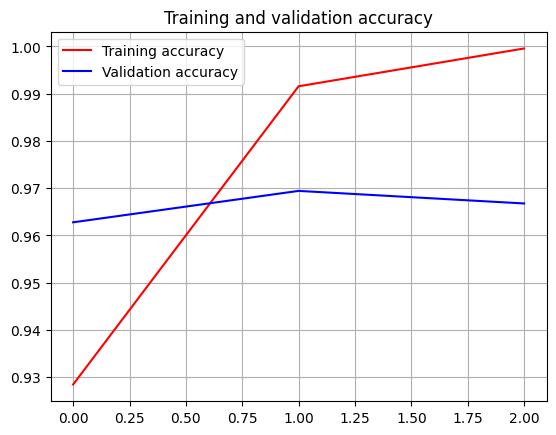

<Figure size 640x480 with 0 Axes>

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.grid(True)
plt.figure()
plt.show()